In [1]:
from model import bootstrapper
from model import DAGLearner
import pandas as pd
import os
import tqdm
import networkx as nx 
import numpy as np 
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
import utils

# DAGLearner

DAGLearner takes in some data and a DAG (as a networkx graph) and implements SuperLearners for every variable with parents in that DAG.

This enables one to perform effect-size estimation without the usual constraints on functional form associated with (linear) path models / structural equation models.

What users need: 

- a dataset
- a dag
- a list of variable types (continuous='cont', binary='bin', categorical='cat')

What DAGLearner does:

- estimates all causal links with SuperLearners  (or optional linear/logistic baseline)
- runs hyperparameter tuning (optional)
- provides ATE estimates for all paths in the model
- provides estimates for any given intervention


This code also provides ways to integrate it into a pipeline with bootstrapping and plotting, for tutorial purposes.


## Import Data, DAG, Causal Ordering, and Variable Types

In [2]:
def sigm(x):
    return 1/(1 + np.exp(-x))

def inv_sigm(x):
    return np.log(x/(1-x))

    
def generate_data(N):
    ''' This function generates a dictionary of data and a DAG'''
    z1 = np.random.binomial(1, 0.5, (N, 1))
    z2 = np.random.binomial(1, 0.65, (N, 1))
    z3 = np.round(np.random.uniform(0, 4, (N, 1)), 0)
    z4 = np.round(np.random.uniform(0, 5, (N, 1)), 0)
    uz5 = np.random.randn(N, 1)
    z5 = 0.2 * z1 + uz5

    # risk vars:
    r1 = np.random.randn(N, 1)
    r2 = np.random.randn(N, 1)
    RM = np.random.randn(N, 1)

    # instrumental vars:
    i1 = np.random.randn(N, 1)
    i2 = np.random.randn(N, 1)

    # treatment:
    ux = np.random.randn(N, 1)
    xp = sigm(-5 + 0.05 * z2 + 0.25 * z3 + 0.6 * z4 + 0.4 * z2 * z4 + 0.15 * z5 + 0.1 * i1 + 0.15 * i2 + 0.1 * ux)
    X = np.random.binomial(1, xp, (N, 1))

    # mediator:
    Um = np.random.randn(N, 1)
    
    # m = 0.8*X + 0.3*Rm*X + 0.15*5Um
    m1 = 0.8 + 0.15 *RM + 0.15 * Um
    m0 = 0.15 * Um
    M = m1 * X + m0 * (1 - X)
    # outcomes:
    Y1 = -1 + 0.3 + m1 - 0.1 * z1 + 0.35 * z2 + 0.25 * z3 + 0.2 * z4 + 0.15 * z2 * z4 + r1 + r2
    Y0 = -1 + m0 - 0.1 * z1 + 0.35 * z2 + 0.25 * z3 + 0.2 * z4 + 0.15 * z2 * z4 + r1 + r2
    Y = Y1 * X + Y0 * (1 - X)

     # colliders:
    C = 0.6 * Y + 0.4 * X + 0.4 * np.random.randn(N, 1)

    all_data = pd.DataFrame(np.concatenate([z1, z2, z3, z4, z5, RM, X, M, i1, i2, r1, r2, Y, C], 1))
    all_data.columns = ['Z1', 'Z2', 'Z3', 'Z4', 'Z5', 'RM', 'X', 'M', 'I1', 'I2', 'R1', 'R2', 'Y', 'C']

    # types can be 'cat' (categorical) 'cont' (continuous) or 'bin' (binary)
    var_types = {'Z1': 'cont', 'Z2': 'cont', 'Z3': 'cont', 'Z4': 'cont', 'Z5': 'cont', 'X': 'bin', 'M': 'cont', 'I1': 'cont',
                     'RM': 'cont', 'I2': 'cont', 'R1': 'cont', 'R2': 'cont', 'Y': 'cont', 'C': 'cont'}
    DAGnx = nx.DiGraph()
    DAGnx.add_edges_from([('Z1', 'Z5'), ('Z2', 'X'), ('Z3', 'X'), ('Z4', 'X'), ('Z5', 'X'),
                          ('Z2', 'Y'), ('Z3', 'Y'), ('Z4', 'Y'), ('Z5', 'Y'),
                          ('R1', 'Y'), ('R2', 'Y'), ('M', 'Y'),('RM', 'M'),
                          ('I1', 'X'), ('I2', 'X'), ('X', 'M'), ('X', 'Y'), ('X', 'C'),
                          ('Y', 'C')])
    return all_data, DAGnx, var_types, m1, m0

X - > M effect: 0.7883376674233898


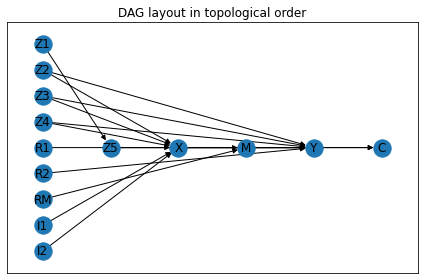

In [3]:
N = 600  # sample size
seed = 42  # random seed
np.random.seed(seed=seed)

df, DAG, var_types, m1, m0 = generate_data(N)

# we will use the effect of X -> M as an example intervention throughout 
# but remember that you can specify multiple interventions <simultaneously>
true_empirical_effect_xm = (m1 - m0).mean()
print('X - > M effect:', true_empirical_effect_xm)
# get a plot:

for layer, nodes in enumerate(nx.topological_generations(DAG)):
    # `multipartite_layout` expects the layer as a node attribute, so add the
    # numeric layer value as a node attribute
    for node in nodes:
        DAG.nodes[node]["layer"] = layer
        
pos = nx.multipartite_layout(DAG, subset_key="layer")
fig, ax = plt.subplots()
nx.draw_networkx(DAG, pos=pos, ax=ax)
ax.set_title("DAG layout in topological order")
fig.tight_layout()
plt.show()

## Simple DAGLearner Usage

In [4]:
# initialise the daglearner with a list of learners:

# Elastic -> elastic net https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html
# LR -> linear or logistic regression https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# MLP -> Multi Layer Perceptron https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
# SV -> Support Vector Machine https://scikit-learn.org/stable/modules/svm.html
# AB -> AdaBoost https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
# RF -> Random Forest https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
# BR -> Bayesian Regression / Naive Bayes https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html
# poly -> polynomial regression https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

learner_list = ['Elastic', 'LR', 'MLP', 'SV', 'AB', 'RF', 'BR', 'poly']

# select k for the number of k-fold splits to do as part of k-CV:
k = 6
daglearner = DAGLearner(dag=DAG,  var_types=var_types, k=k)

# fit the superlearners:
daglearner.fit(data=df, verbose=True)

# estimate all ATEs for do(0) and do(1) interventions:
ATEs = daglearner.get_0_1_ATE(data=df)

# estimate specific inteventions and update dataset with result:
int_val_nodes = {'X': 0}
interventional_dataset0 = daglearner.infer(data=df, intervention_nodes_vals=int_val_nodes)

int_val_nodes = {'X': 1}
interventional_dataset1 = daglearner.infer(data=df, intervention_nodes_vals=int_val_nodes)

 

Training model for var: Z5
r2 : 0.009668136733157695
mae : 0.7698599291633488
mse : 0.9332529846041436
expl_var : 0.009668526838534697
medae : 0.6486154155770804
Training model for var: X
acc : 0.8733333333333333
balacc : 0.6352993573837247
prec : 0.7297297297297297
rec : 0.2903225806451613
f1 : 0.41538461538461535
Training model for var: M
r2 : 0.7595207272469991
mae : 0.12717865163852146
mse : 0.024915049110845876
expl_var : 0.7595230671212957
medae : 0.1101697996751842
Training model for var: Y
r2 : 0.999271967500497
mae : 0.046504983011086194
mse : 0.0023179323239785614
expl_var : 0.9992719724572913
medae : 0.04742905407402753
Training model for var: C
r2 : 0.8839179998439766
mae : 0.32794492620560434
mse : 0.17106970559698248
expl_var : 0.8839182581460808
medae : 0.283767980456277


## Checking Results

As we generated the data we know the ground-truth effect sizes.


In [5]:
# estimate specific inteventions and update dataset with result:
int_val_nodes = {'X': 0}  # (you can add more to this dict)
interventional_dataset0 = daglearner.infer(data=df, intervention_nodes_vals=int_val_nodes)

int_val_nodes = {'X': 1}  # (you can add more to this dict)
interventional_dataset1 = daglearner.infer(data=df, intervention_nodes_vals=int_val_nodes)

# get average results of interventions
ATE_dataset =  np.round((interventional_dataset1 - interventional_dataset0).mean(), 3)

print('Estimated effect:', ATE_dataset['M'], ' True effect:', true_empirical_effect_xm,
      ' Error on ATE: ', np.round(abs(ATE_dataset['M'] - true_empirical_effect_xm), 3))

Estimated effect: 0.768  True effect: 0.7883376674233898  Error on ATE:  0.02


## Baseline Performance
DAGLearner has the option to use linear/logistic models for everything.

Just set baseline=True when instantiating a DAGLearner object.

In this case, because the DGP is linear (besides one moderation effect), we expect this to perform very well.


In [6]:
# select k for the number of k-fold splits to do as part of k-CV:
k = 6

# initialise the daglearner with linear/logistic models:
daglearner = DAGLearner(dag=DAG, k = k, var_types=var_types, baseline=True)

# fit the daglearner:
daglearner.fit(data=df, verbose=True)

# estimate specific inteventions and update dataset with result:
int_val_nodes = {'X': 0}
interventional_dataset0 = daglearner.infer(data=df, intervention_nodes_vals=int_val_nodes)

int_val_nodes = {'X': 1}
interventional_dataset1 = daglearner.infer(data=df, intervention_nodes_vals=int_val_nodes)

# get average results of interventions
ATE_dataset =  np.round((interventional_dataset1 - interventional_dataset0).mean(), 3)

print('Estimated effect:', ATE_dataset['M'], ' True effect:', true_empirical_effect_xm,
      ' Error on ATE: ', np.round(abs(ATE_dataset['M'] - true_empirical_effect_xm), 3))

Training model for var: Z5
r2 : 0.0096700649588074
mae : 0.769851896474947
mse : 0.9332511675139245
expl_var : 0.00967006495880729
medae : 0.648225332664017
Training model for var: X
acc : 0.865
balacc : 0.6259782401221607
prec : 0.65
rec : 0.27956989247311825
f1 : 0.39097744360902253
Training model for var: M
r2 : 0.7325650142109936
mae : 0.1338931204686068
mse : 0.02770781751213656
expl_var : 0.7325650142109936
medae : 0.11169682045343739
Training model for var: Y
r2 : 0.9955774066634112
mae : 0.09573977698508473
mse : 0.014080789055007158
expl_var : 0.9955774066634112
medae : 0.0862796506262633
Training model for var: C
r2 : 0.8806501259216029
mae : 0.3331796991820996
mse : 0.17588556188027468
expl_var : 0.8806501259216029
medae : 0.278166501713033
Estimated effect: 0.761  True effect: 0.7883376674233898  Error on ATE:  0.027


## Getting some bootstraps:

In [7]:
bootstraps = 30
bootstrap_subsample_size =  int(0.6 * N)
k = 4
    
ATE_estimates = []
for i in tqdm.tqdm(range(bootstraps)):
    seed += 1
    bootstrap_data = df.sample(n=bootstrap_subsample_size, replace=True)

    daglearner = DAGLearner(dag=DAG, k=k, var_types=var_types, seed=seed)
    # fit the daglearner:
    daglearner.fit(data=bootstrap_data, verbose=False)

    # estimate all ATEs for do(0) and do(1) interventions:
    ATEs = daglearner.get_0_1_ATE(data=bootstrap_data)
    ATE_estimates.append(ATEs['X->M']) # this is the direct effect of X on M


100%|██████████| 30/30 [05:08<00:00, 10.28s/it]


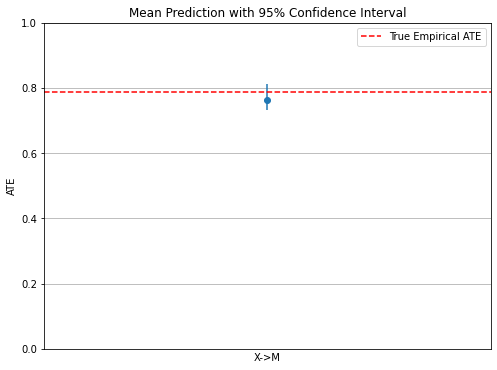

In [8]:
ATE_estimates = np.asarray(ATE_estimates)
# Calculate 2.5th and 97.5th percentiles for prediction intervals
lower = np.percentile(ATE_estimates, 2.5)
upper = np.percentile(ATE_estimates, 97.5)
mean = ATE_estimates.mean()

fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(1, mean, yerr=[[mean - lower], [upper - mean]], fmt='o')
ax.set_xlim(0, 2) 
ax.set_xlabel('X->M')
ax.axhline(y=true_empirical_effect_xm, color='r', linestyle='--', label='True Empirical ATE')
ax.set_ylabel('ATE')
ax.set_title('Mean Prediction with 95% Confidence Interval')
plt.ylim(0,1)
plt.legend()
x_pos = 1
ax.set_xticks([])
plt.grid()
plt.show()

### We also provide a function for the bootstrapping

Some example usage of 'bootstrapper' function is given below.

In [9]:

# this outputs all the ATE estimates for each bootstrap:
bs_results_ATE = bootstrapper(num_bootstraps=10, subsample_size=bootstrap_subsample_size,
                              k=k, data=df, dag=DAG, var_types=var_types, baseline=True)

int_nodes_val =  int_nodes_val = int_val_nodes = {'X': 0}
# by adding one more argument this outputs the interventional dataset for each bootstrap:
bs_results_int = bootstrapper(num_bootstraps=10, subsample_size=bootstrap_subsample_size,
                              k=k, int_nodes_val=int_nodes_val,
                               data=df, dag=DAG, var_types=var_types, baseline=True)

int_nodes_val = int_val_nodes = {'X': 0}
int_nodes_valb = int_val_nodes = {'X': 1}
# by adding one more argument this outputs the interventional DIFFERENCE/CONTRAST datasets for each bootstrap:
bs_results_contrast = bootstrapper(num_bootstraps=10, subsample_size=bootstrap_subsample_size,
                                   k=k, int_nodes_val=int_nodes_val,int_nodes_valb=int_nodes_valb,
                                   data=df, dag=DAG, var_types=var_types, baseline=True)

100%|██████████| 10/10 [00:00<00:00, 26.46it/s]


### Getting response curves

As SuperLearners are non-linear, it makes sense to exploit this to generate a set of plots across a range of effect settings.

The following example explores the ATE of X on M but for different values of RM, which is an interaction term.

Training DAGLearner models
Training model for var: Z5
r2 : 0.009516883404233734
mae : 0.7698890118808891
mse : 0.933395520279189
expl_var : 0.009540935381334048
medae : 0.651988059130013
Training model for var: X
acc : 0.8783333333333333
balacc : 0.6382579372653815
prec : 0.7941176470588235
rec : 0.2903225806451613
f1 : 0.4251968503937008
Training model for var: M
r2 : 0.7615855834371492
mae : 0.12692337828824013
mse : 0.024701118019008022
expl_var : 0.761589543745935
medae : 0.11149264466737191
Training model for var: Y
r2 : 0.9992702417446023
mae : 0.046471410679727154
mse : 0.0023234268388173953
expl_var : 0.999270243814116
medae : 0.04725823566110438
Training model for var: C
r2 : 0.8838499089323171
mae : 0.3279824910227102
mse : 0.17117005097521296
expl_var : 0.8838499203008636
medae : 0.2816288658053454
Generating Interventions


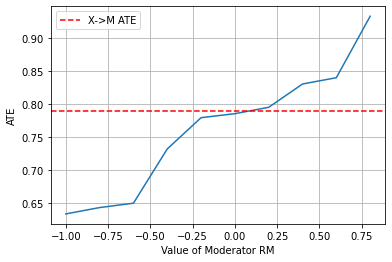

In [14]:
# varying treatment level:
increment = 0.2
t1s = np.arange(-1, 1, increment)
k = 4
print('Training DAGLearner models')
daglearner = DAGLearner(dag=DAG, k=k, var_types=var_types)
daglearner.fit(data=df, verbose=True)


effects = []
print('Generating Interventions')
for t in range(len(t1s)):
    t1 = t1s[t]
    int_val_nodes0 = {'X': 0, 'RM':t1} # here we intervene on the moderator RM as well as X
    interventional_dataset0 = daglearner.infer(data=df, intervention_nodes_vals=int_val_nodes0)
    int_val_nodes1 = {'X': 1, 'RM':t1}
    interventional_dataset1 = daglearner.infer(data=df, intervention_nodes_vals=int_val_nodes1)
    
    # get average results of interventions
    effect = (interventional_dataset1['M'] - interventional_dataset0['M']).mean()
    effects.append(effect)

plt.plot(t1s, effects)
plt.ylabel('ATE')
plt.axhline(y=true_empirical_effect_xm, color='r', linestyle='--', label='X->M ATE')
plt.xlabel('Value of Moderator RM')
plt.legend()
plt.grid()
plt.show()

## Combining Bootstrapping witht the non-linear effect estimation

We can run the above treatment effect estimation but with the bootstrapping, to obtain CIs
(this is computationally expensive)

Iteration: 0


100%|██████████| 20/20 [03:14<00:00,  9.71s/it]


Iteration: 1


100%|██████████| 20/20 [02:55<00:00,  8.77s/it]


Iteration: 2


100%|██████████| 20/20 [02:58<00:00,  8.91s/it]


Iteration: 3


100%|██████████| 20/20 [03:16<00:00,  9.82s/it]


Iteration: 4


100%|██████████| 20/20 [03:21<00:00, 10.06s/it]


Iteration: 5


100%|██████████| 20/20 [03:27<00:00, 10.36s/it]


Iteration: 6


100%|██████████| 20/20 [03:27<00:00, 10.38s/it]


Iteration: 7


100%|██████████| 20/20 [03:28<00:00, 10.41s/it]


Iteration: 8


100%|██████████| 20/20 [03:31<00:00, 10.56s/it]


Iteration: 9


100%|██████████| 20/20 [03:31<00:00, 10.55s/it]


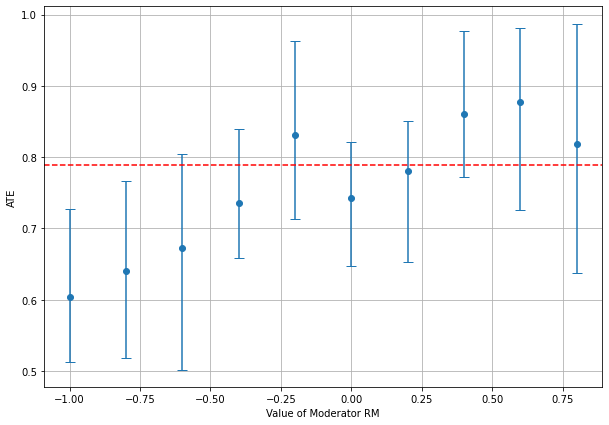

In [11]:

bootstraps = 20
bootstrap_subsample_size = int(0.6 * N)
k = 4

# varying treatment level:
increment = 0.2
t1s = np.arange(-1, 1, increment)

effects = []
uppers = []
lowers = []

for t in range(len(t1s)):  # outer loop for each intended intervention size
    print('Iteration:', t)
    t1 = t1s[t]
       
    int_val_nodes0 = {'X': 0, 'RM':t1}
    int_val_nodes1 = {'X': 1, 'RM':t1}
    
    bs_results_contrast = bootstrapper(num_bootstraps=bootstraps, subsample_size=bootstrap_subsample_size,
                                   k=k, int_nodes_val=int_val_nodes0, int_nodes_valb=int_val_nodes1,
                                   data=df, dag=DAG, var_types=var_types, baseline=False)
    ATE_estimates = []
    for i in range(bootstraps):
         # extracts the bootstrapped effects of the intervention(s) on variable 'M'
        ATE_estimates.append(bs_results_contrast[i]['M'].mean()) 
        
    ATE_estimates = np.asarray(ATE_estimates)
    lower = np.percentile(ATE_estimates, 2.5)
    upper = np.percentile(ATE_estimates, 97.5)
    mean = ATE_estimates.mean()
    
    # append the results for this particular intervention size
    effects.append(mean)
    lowers.append(lower)
    uppers.append(upper)
    

lowers = np.asarray(effects) - np.asarray(lowers)
uppers = np.asarray(uppers) - np.asarray(effects)

plt.figure(figsize=(10,7))
plt.errorbar(t1s, effects, yerr=[lowers, uppers], fmt='o', capsize=5)
plt.axhline(y=true_empirical_effect_xm, color='r', linestyle='--', label='X->M ATE')
plt.xlabel('Value of Moderator RM')
plt.ylabel('ATE')
plt.grid(True)
plt.show()  
    